In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess
from warnings import simplefilter

simplefilter("ignore")

In [ ]:
'''
A Basic Roadmap (Borrowed from Kaggle Learn)
    1. Train and predict with first model
        model_1.fit(X_train_1, y_train)
        y_pred_1 = model_1.predict(X_train)

    2. Train and predict with second model on residuals
        model_2.fit(X_train_2, y_train - y_pred_1)
        y_pred_2 = model_2.predict(X_train_2)

    3. Add results from both models to get overall predictions
        y_pred = y_pred_1 + y_pred_2
'''

### Part 1 - Train and Predict with the First Model (Linear Regression)

In [2]:
# Import JP Morgan quarterly financial data going back 30 years

link = "https://docs.google.com/spreadsheets/d/1aEMvm35HGy09zWJMJLT9pAHXg7E2jaSW/export"
dataset1 = pd.read_excel(link, sheet_name='FinStmts', index_col='Date')
dataset1.head()

,Revenue,TotalAssets,TotalLiabilities
Date,,,
2022-12-31_Q4,34547000000,3665743000000,3373411000000
2022-09-30_Q3,32716000000,3773884000000,3485866000000
2022-06-30_Q2,30709000000,3841314000000,3555171000000
2022-03-31_Q1,30718000000,3954687000000,3668788000000
2021-12-31_Q4,29288000000,3743567000000,3449440000000


In [3]:
# Some quick data cleaning

dataset1.index = dataset1.index.str.split('_').str[0]
dataset1.index = pd.to_datetime(dataset1.index)
dataset1 = dataset1.iloc[::-1]
dataset1.head()

,Revenue,TotalAssets,TotalLiabilities
Date,,,
1990-03-31,928100000,74150000000,70244000000
1990-06-30,848200000,75216000000,71217000000
1990-09-30,856100000,74444000000,70564000000
1990-12-31,874200000,73019000000,69112000000
1991-03-31,866200000,72489000000,68546000000


In [4]:
# Importing Economic data to provide some useful insights

dataset2 = pd.read_excel(link, sheet_name='EconData', index_col='Date', engine='openpyxl')
dataset2

,FEDFUNDS,DPRIME,MORTGAGE30US,CPILFESL
Date,,,,
2023-03-01,4.65,8.00,6.32,305.240
2023-02-01,4.57,7.75,6.50,304.070
2023-01-01,4.33,7.50,6.13,302.702
2022-12-01,4.10,7.50,6.42,301.460
2022-11-01,3.78,7.00,6.58,300.261
...,...,...,...,...
1990-05-01,8.18,10.00,10.33,134.400
1990-04-01,8.26,10.00,10.56,134.000
1990-03-01,8.28,10.00,10.22,133.500


In [5]:
# Resampling monthly data to make it match the quarterly index of the rest of the data

dataset2 = pd.DataFrame(dataset2.resample('Q', label='right').last())
dataset2.head()

,FEDFUNDS,DPRIME,MORTGAGE30US,CPILFESL
Date,,,,
1990-03-31,8.28,10.0,10.22,133.5
1990-06-30,8.29,10.0,10.15,135.1
1990-09-30,8.20,10.0,10.22,137.1
1990-12-31,7.31,10.0,9.68,138.6
1991-03-31,6.12,9.0,9.52,140.5


In [6]:
# Additional data cleaning

dataset2 = dataset2[:-1]
dataset2.tail()

,FEDFUNDS,DPRIME,MORTGAGE30US,CPILFESL
Date,,,,
2021-12-31,0.08,3.25,3.11,285.193
2022-03-31,0.20,3.50,4.67,289.046
2022-06-30,1.21,4.75,5.70,294.017
2022-09-30,2.56,6.25,6.70,298.339
2022-12-31,4.10,7.50,6.42,301.460


In [7]:
# Combining the two dataframes

df = pd.concat([dataset1, dataset2], axis=1)
df

,Revenue,TotalAssets,TotalLiabilities,FEDFUNDS,DPRIME,MORTGAGE30US,CPILFESL
Date,,,,,,,
1990-03-31,928100000,74150000000,70244000000,8.28,10.00,10.22,133.500
1990-06-30,848200000,75216000000,71217000000,8.29,10.00,10.15,135.100
1990-09-30,856100000,74444000000,70564000000,8.20,10.00,10.22,137.100
1990-12-31,874200000,73019000000,69112000000,7.31,10.00,9.68,138.600
1991-03-31,866200000,72489000000,68546000000,6.12,9.00,9.52,140.500
...,...,...,...,...,...,...,...
2021-12-31,29288000000,3743567000000,3449440000000,0.08,3.25,3.11,285.193
2022-03-31,30718000000,3954687000000,3668788000000,0.20,3.50,4.67,289.046
2022-06-30,30709000000,3841314000000,3555171000000,1.21,4.75,5.70,294.017


In [8]:
# Separate the data as needed for the two separate models

df_LR = df['Revenue']   # The linear model only needs the revenue column (we will create features)
df_xgb = df             # The xgb model should benefit from all of the data

In [9]:
# Create additional features for Linear Regression model to train the trend

dp = DeterministicProcess(
     index=df_LR.index,
     constant=True,
     order=1,
     drop=True
)

X = dp.in_sample()

X.head()              # Training data for the linear model

,const,trend
Date,,
1990-03-31,1.0,1.0
1990-06-30,1.0,2.0
1990-09-30,1.0,3.0
1990-12-31,1.0,4.0
1991-03-31,1.0,5.0


In [10]:
# Splitting the data to be used with the linear regression model

y = df_LR
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X, y, test_size=20, shuffle=False)

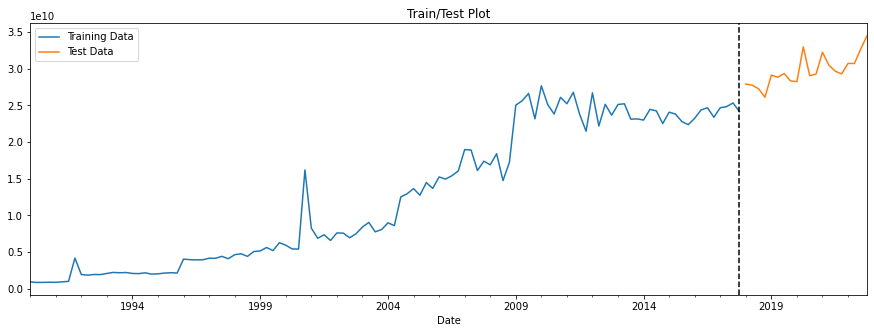

In [11]:
# Visualizing the Target data ('Revenue' column)

fig, ax = plt.subplots(figsize=(15,5))
y_train_LR.plot(ax=ax, label='Training Data', title='Train/Test Plot')
y_test_LR.plot(ax=ax, label='Test Data')
ax.axvline('2017-12-31', color='black', ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

In [12]:
# Fit the Linear Regression model

model_1 = LinearRegression(fit_intercept=False)
model_1.fit(X_train_LR, y_train_LR)

# Predict
y_pred_LR = pd.Series(model_1.predict(X_train_LR), index = y_train_LR.index)
y_fore_LR = pd.Series(model_1.predict(X_test_LR), index = y_test_LR.index)

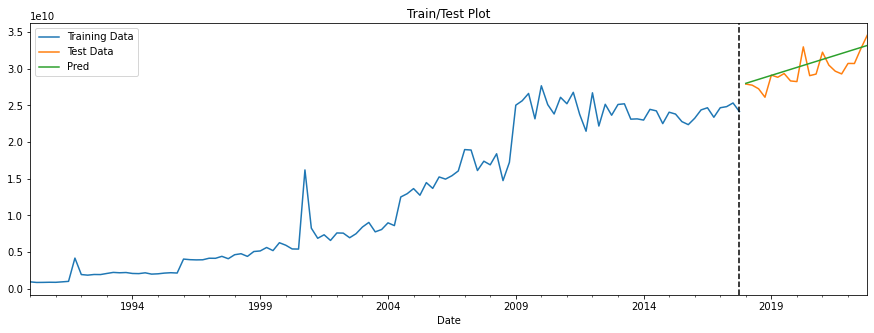

In [13]:
# Plot results from the linear model

fig, ax = plt.subplots(figsize=(15,5))
y_train_LR.plot(ax=ax, label='Training Data', title='Train/Test Plot')
y_test_LR.plot(ax=ax, label='Test Data')
y_fore_LR.plot(ax=ax, label='Pred')
ax.axvline('2017-12-31', color='black', ls='--')
ax.legend(['Training Data', 'Test Data', 'Pred'])
plt.show()

### Part 2 - Train and predict with second model (XGBoost) on residuals

In [14]:
def add_all_features(df_xgb):
    # Adds additional features to the data for improved performance
    df_xgb.copy()
    df_xgb['Year'] = df_xgb.index.year
    df_xgb['Quarter'] = df_xgb.index.quarter
    df_xgb['lag1'] = df_xgb['Revenue'].shift(1)
    df_xgb['lag2'] = df_xgb['Revenue'].shift(2)
    return df_xgb

In [15]:
# Add features and prep data for the second model

df_xgb = add_all_features(df_xgb).iloc[2:]     # drop nulls created by shift funtion

y = df_xgb['Revenue']
X = df_xgb.iloc[:,1:]
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=20, shuffle=False)
X.head()

,TotalAssets,TotalLiabilities,FEDFUNDS,DPRIME,MORTGAGE30US,CPILFESL,Year,Quarter,lag1,lag2
Date,,,,,,,,,,
1990-09-30,74444000000,70564000000,8.20,10.0,10.22,137.1,1990,3,848200000.0,928100000.0
1990-12-31,73019000000,69112000000,7.31,10.0,9.68,138.6,1990,4,856100000.0,848200000.0
1991-03-31,72489000000,68546000000,6.12,9.0,9.52,140.5,1991,1,874200000.0,856100000.0
1991-06-30,74130000000,70142000000,5.90,8.5,9.67,141.8,1991,2,866200000.0,874200000.0
1991-09-30,73729000000,69651000000,5.45,8.0,8.92,143.4,1991,3,928500000.0,866200000.0


In [16]:
# Remove the trend by subtracting out the regression model's results

y_pred_LR = y_pred_LR.iloc[2:]                 # slice to match length of X_train_LR
y_train_LR = y_train_LR.iloc[2:]               # slice to match length of X_train_LR
y_resid = y_train_LR.subtract(y_pred_LR, axis=0)
y_resid

Date
1990-09-30    2.749897e+09
1990-12-31    2.496217e+09
1991-03-31    2.216437e+09
1991-06-30    2.006957e+09
1991-09-30    1.801977e+09
                  ...     
2016-12-31   -3.267105e+09
2017-03-31   -2.239885e+09
2017-06-30   -2.361665e+09
2017-09-30   -2.132445e+09
2017-12-31   -3.577225e+09
Length: 110, dtype: float64

In [17]:
# Pause to check that the residuals make sense in context
# (The code in the last cell just performed:    Revenue - Trend = Residuals)

pd.options.display.float_format = '{:,.0f}'.format

resid_check = pd.concat([y_train_LR, y_pred_LR, y_resid], axis=1)
resid_check.columns = ['Revenue', 'Trend', 'Residuals']
resid_check.astype(float) # What's up with 'Revenue'?????
resid_check

,Revenue,Trend,Residuals
Date,,,
1990-09-30,856100000,"-1,893,796,876","2,749,896,876"
1990-12-31,874200000,"-1,622,016,861","2,496,216,861"
1991-03-31,866200000,"-1,350,236,846","2,216,436,846"
1991-06-30,928500000,"-1,078,456,831","2,006,956,831"
1991-09-30,995300000,"-806,676,816","1,801,976,816"
...,...,...,...
2016-12-31,23376000000,"26,643,104,703","-3,267,104,703"
2017-03-31,24675000000,"26,914,884,718","-2,239,884,718"
2017-06-30,24825000000,"27,186,664,733","-2,361,664,733"


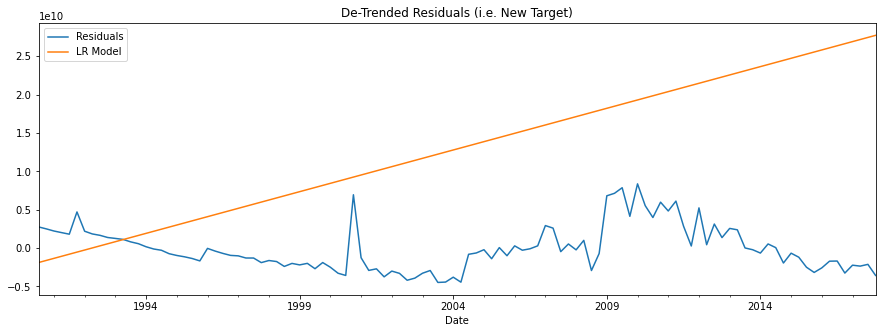

In [18]:
# Visual Comparison of the Linear Model Trend and the Residuals we will be testing

fig, ax = plt.subplots(figsize=(15, 5))
resid_check.Residuals.plot(ax=ax, label='Residuals', title='De-Trended Residuals (i.e. New Target)')
y_pred_LR.plot(ax=ax, label='LR Model')
ax.legend(['Residuals', 'LR Model'])
plt.show()

In [19]:
# Train the XGBoost Model

model_2 = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=10, learning_rate=0.001)
model_2.fit(X_train_xgb, y_resid, 
            eval_set=[(X_train_xgb, y_resid), (X_test_xgb, y_test_xgb)],
            verbose=100)

# Create Predictions

y_pred_xgb = pd.Series(model_2.predict(X_train_xgb), index=y_train_xgb.index)
y_fore_xgb = pd.Series(model_2.predict(X_test_xgb), index=y_test_xgb.index)

[0]	validation_0-rmse:2899681335.68008	validation_1-rmse:29799726999.56054
[10]	validation_0-rmse:2875776434.94605	validation_1-rmse:29806121131.77619


### Part 3 - Add results from both models to get overall predictions
####   (This is where it becomes very obvious something went wrong)

In [20]:
# Add this XGB model's results to the Linear Regression model's results

y_pred_boosted = y_pred_LR.add(y_pred_xgb, axis=0)
y_fore_boosted = y_fore_LR.add(y_fore_xgb, axis=0)

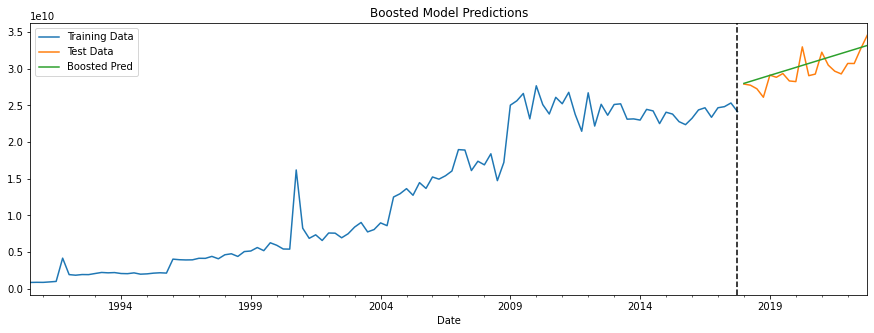

In [21]:
# Plot the Results (Essentially no change from the first model)

fig, ax = plt.subplots(figsize=(15, 5))
y_train_xgb.plot(ax=ax, label='Training Data', title='Boosted Model Predictions')
y_test_xgb.plot(ax=ax, label='Test Data')
y_fore_boosted.plot(ax=ax, label='Boosted Pred')
ax.axvline('2017-12-31', color='black', ls='--')
ax.legend(['Training Data', 'Test Data', 'Boosted Pred'])
plt.show()

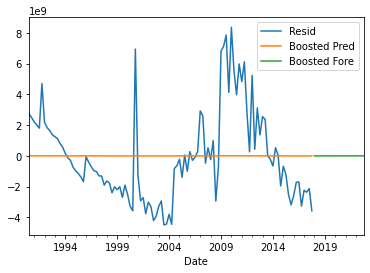

In [22]:
# Zooming in on problem (the XGBoost model did not fit itself to the training data)

fig, ax = plt.subplots()
y_resid.plot(ax=ax, label='Resid')
y_pred_xgb.plot(ax=ax, label='Boosted Pred')
y_fore_xgb.plot(ax=ax, label='Boosted Fore')
ax.legend(['Resid', 'Boosted Pred', 'Boosted Fore'])
plt.show()

In [ ]:
'''
My expection is that the poor performance is because the XGBoost Model just simply needs
more data in order to be effective. 30 years of data is about as much as I can gather efficiently,
but that only translates to a training data size of 110 records.
'''